In [1]:
import tensorflow as tf
import numpy as np
from keras_cv import visualization
from data.prepate_data import run_data_preparation_pipeline
from models.csp_darknet import create_xs_csp_darknet_yolov8
from models.ghostnet_v2 import create_0_5_ghostnet_yolov8
from models.shufflenet_v2 import create_0_5_shufflenet_yolov8
from quantization.lite_wrapper import YOLOv8LiteWrapper
from keras.callbacks import CSVLogger
from profiling.coco_metric_callback import EvaluateCOCOMetricsCallback
from profiling.profilers import ModelsProfiler, FlopsExtractor, InferenceProfiler, COCOMetricsCalculator
import warnings
warnings.filterwarnings("ignore")

num_classes = 2
input_shape = (640, 640, 3)


2025-11-10 13:20:25.171038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
shuffle_lite_model = YOLOv8LiteWrapper("../quantized_models/shuffle.tflite")
ghost_lite_model = YOLOv8LiteWrapper("../quantized_models/ghost.tflite")
csp_lite_model = YOLOv8LiteWrapper("../quantized_models/csp.tflite")

In [4]:
gathered_data = run_data_preparation_pipeline()
train_ds, val_ds = gathered_data['train_ds'], gathered_data['val_ds']
val_ds = val_ds.map(lambda imgs, labels: (tf.cast(imgs, tf.float16), labels))
cat_mapping_r = gathered_data['cat_mapping_r']
cat_mapping = gathered_data['cat_mapping']

Path to dataset files: /Users/bsintsov/.cache/kagglehub/datasets/trainingdatapro/cars-video-object-tracking/versions/3


In [5]:
example_data_for_inf = val_ds.take(1)
example_data_for_inf = next(iter(example_data_for_inf))[0][:1]

In [6]:
import tensorflow as tf
import warnings
tf.experimental.numpy.experimental_enable_numpy_behavior()
from profiling.profilers import COCOMetricsCalculatorLite, InferenceProfiler

warnings.filterwarnings("ignore")

profilers = [
    COCOMetricsCalculatorLite(val_ds),
    InferenceProfiler(repeats=50, device='CPU:0', warmup_steps=10, batch_timing=True),
]

models = {
    'ShuffleNetV2-YOLOv8': shuffle_lite_model,
    'CSPDarkNet-YOLOv8': csp_lite_model,
    'GhostNetv2-YOLOv8': ghost_lite_model,
}

general_profiles = ModelsProfiler(profilers=profilers)
profile_results = general_profiles.profile(models, tf.cast(example_data_for_inf, tf.float16))

RUNNING  <profiling.profilers.COCOMetricsCalculatorLite object at 0x14b8bbd50> FOR MODEL ShuffleNetV2-YOLOv8


2025-11-10 13:21:12.491934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RUNNING  <profiling.profilers.InferenceProfiler object at 0x14b7f7b10> FOR MODEL ShuffleNetV2-YOLOv8
RUNNING  <profiling.profilers.COCOMetricsCalculatorLite object at 0x14b8bbd50> FOR MODEL CSPDarkNet-YOLOv8


2025-11-10 13:21:25.513296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RUNNING  <profiling.profilers.InferenceProfiler object at 0x14b7f7b10> FOR MODEL CSPDarkNet-YOLOv8
RUNNING  <profiling.profilers.COCOMetricsCalculatorLite object at 0x14b8bbd50> FOR MODEL GhostNetv2-YOLOv8


2025-11-10 13:21:38.177140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


RUNNING  <profiling.profilers.InferenceProfiler object at 0x14b7f7b10> FOR MODEL GhostNetv2-YOLOv8


In [8]:
profile_results

MaP  MaP@[IoU=50]  MaP@[IoU=75]  MaP@[area=small]  MaP@[area=medium]  \
0  0.853684      0.970220      0.949320          0.790077           0.922212   
1  0.837446      0.989909      0.960142          0.787161           0.888917   
2  0.886519      0.980082      0.970141          0.850833           0.923191   

   MaP@[area=large]  Recall@[max_detections=1]  Recall@[max_detections=10]  \
0          0.889871                   0.094073                    0.883748   
1          0.913252                   0.092925                    0.875717   
2          0.877019                   0.103442                    0.910516   

   Recall@[max_detections=100]  Recall@[area=small]  ...  std_latency_sec  \
0                     0.883748             0.820325  ...     0.000000e+00   
1                     0.875717             0.824390  ...     1.387779e-17   
2                     0.910516             0.880081  ...     6.938894e-18   

   CPU:0_fps  ram_delta_mb  cpu_percent_before  cpu_percent_after  \
0  13.277194          0.00                 0.2                0.1   
1  11.879270          0.00                 0.1                0.1   
2  16.119495         -0.01                 0.1                0.1   

   cpu_user_time_delta_s  cpu_sys_time_delta_s  gpu_current_mem_mb  \
0                11.9109                0.6829                None   
1                13.3510                0.7777                None   
2                 6.8085                0.5948                None   

   gpu_peak_mem_mb                model  
0             None  ShuffleNetV2-YOLOv8  
1             None    CSPDarkNet-YOLOv8  
2             None    GhostNetv2-YOLOv8  

[3 rows x 27 columns]

In [10]:
example_data_for_inf

<tf.Tensor: shape=(1, 640, 640, 3), dtype=float16, numpy=
array([[[[152., 160.,  80.],
         [170., 178.,  98.],
         [150., 157.,  81.],
         ...,
         [ 37.,  42.,  39.],
         [ 31.,  36.,  35.],
         [ 28.,  33.,  32.]],

        [[136., 144.,  64.],
         [130., 138.,  58.],
         [143., 150.,  73.],
         ...,
         [ 35.,  40.,  36.],
         [ 28.,  33.,  32.],
         [ 26.,  31.,  30.]],

        [[135., 143.,  63.],
         [143., 151.,  71.],
         [133., 140.,  64.],
         ...,
         [ 32.,  37.,  33.],
         [ 26.,  31.,  30.],
         [ 26.,  31.,  30.]],

        ...,

        [[123., 137., 158.],
         [127., 141., 162.],
         [124., 138., 159.],
         ...,
         [113., 118., 126.],
         [113., 118., 126.],
         [112., 117., 125.]],

        [[124., 138., 159.],
         [124., 138., 159.],
         [124., 138., 160.],
         ...,
         [113., 118., 126.],
         [114., 119., 127.],
         

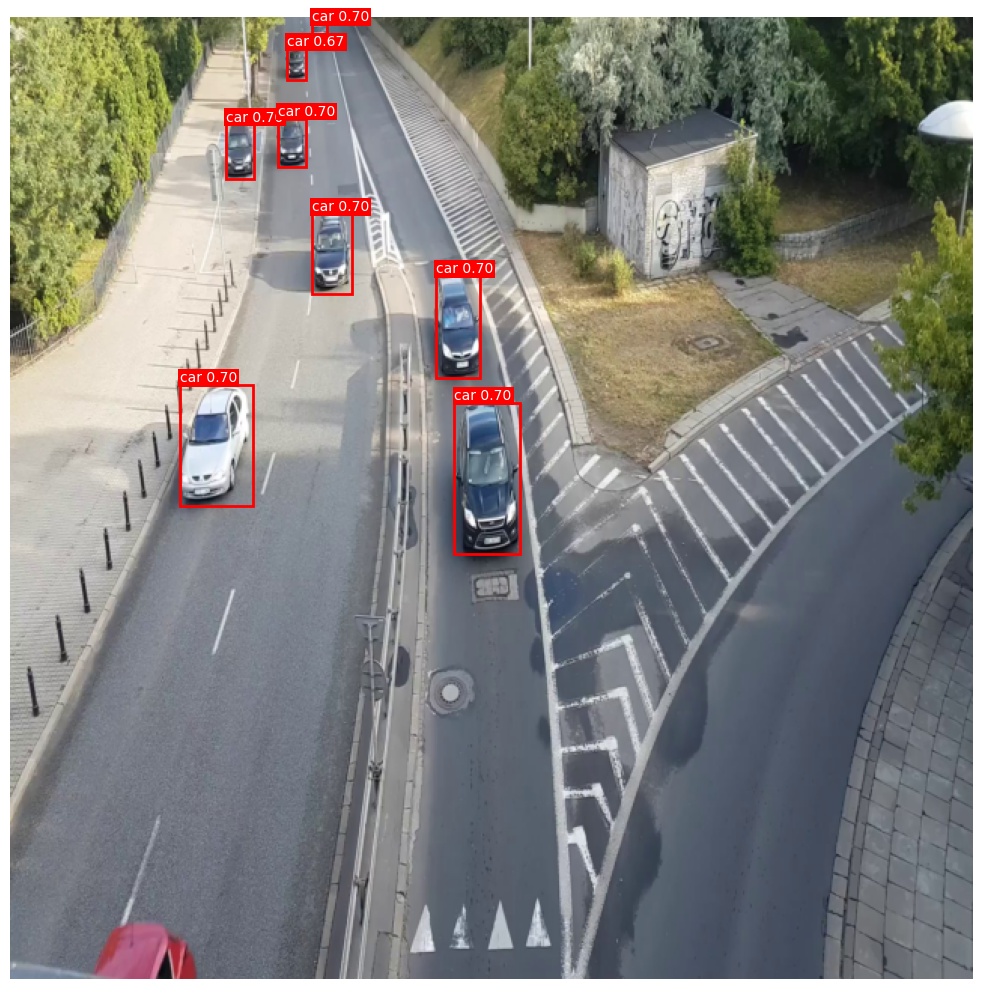

In [23]:
shuffle_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])

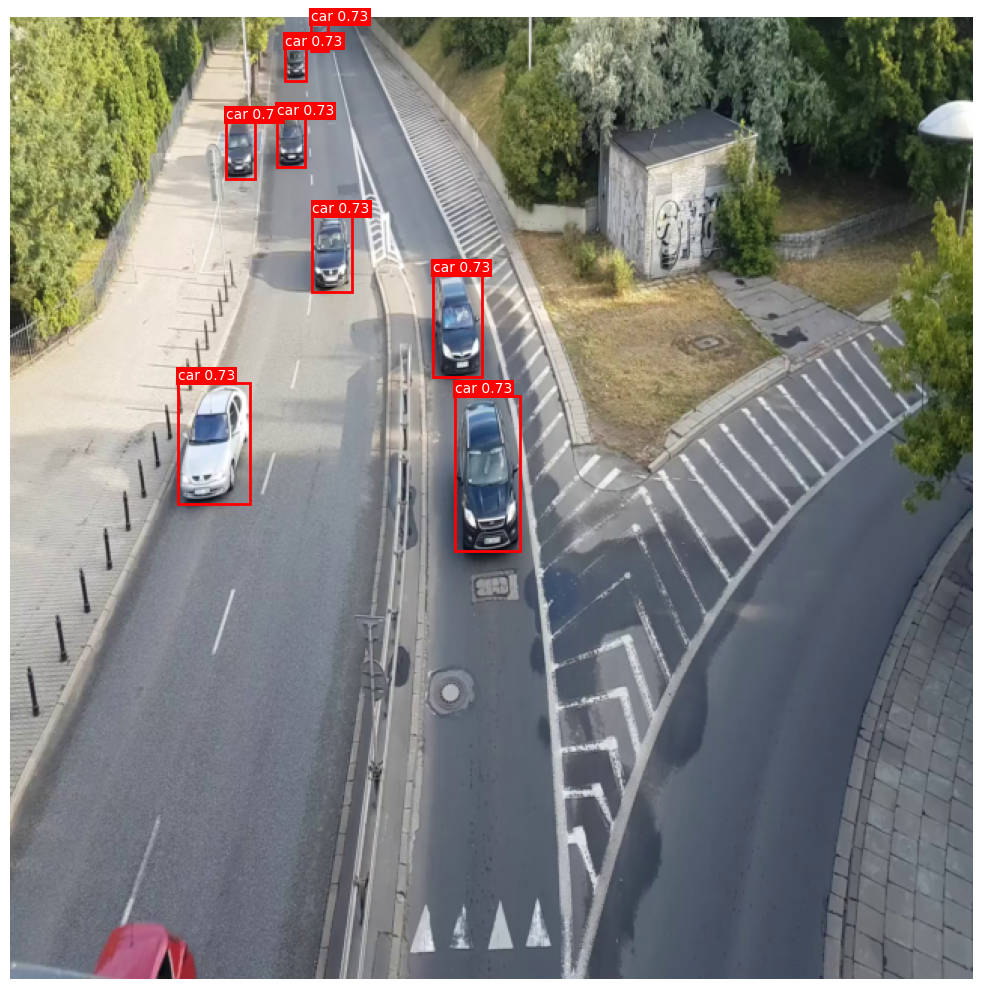

In [22]:
csp_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])

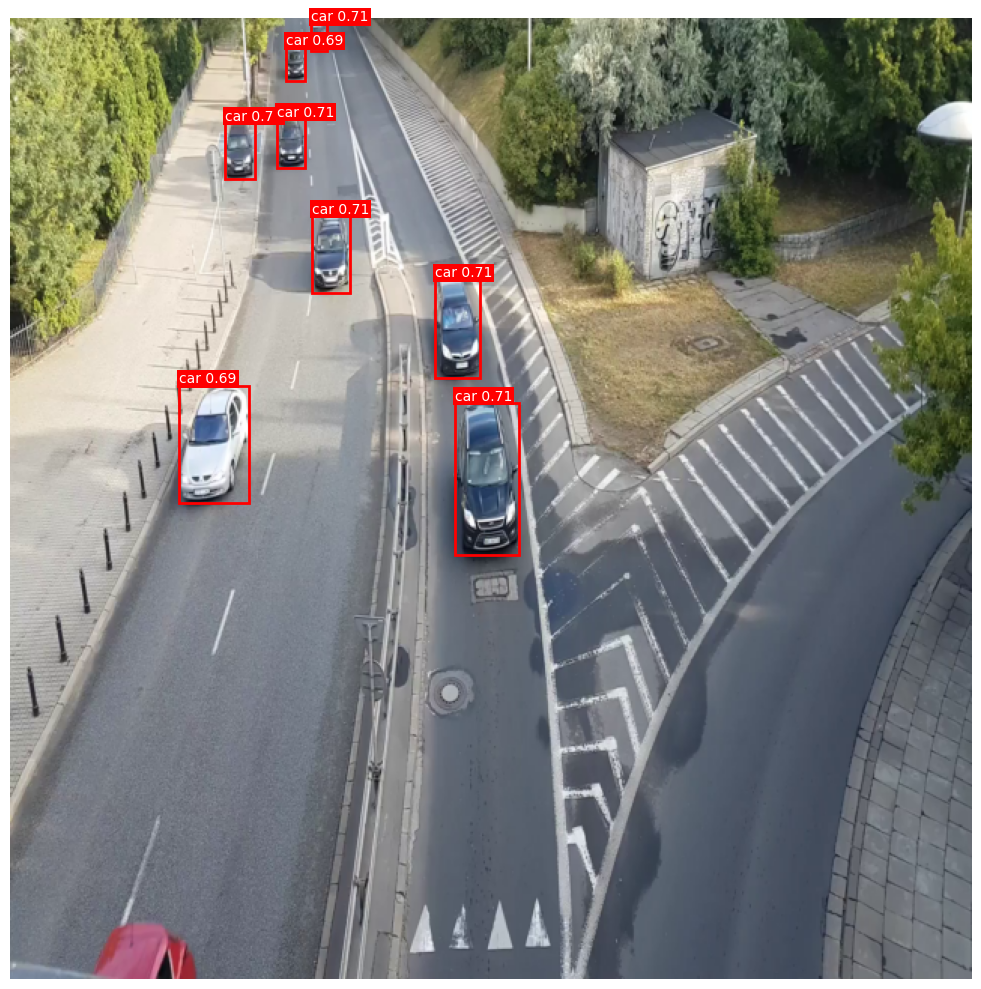

In [21]:
ghost_lite_model.detect_with_plot(tf.cast(example_data_for_inf, tf.float16).numpy(), ['car', 'minivan'])